In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the data
df = pd.read_csv('../data/processed/elements_processed.csv')

# Filter for midfielders (assuming element_type = 3 represents midfielders)
midfielders = df[df['element_type'] == 3]

# Select features relevant to midfielder performance
features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
    'yellow_cards', 'red_cards', 'bonus', 'bps', 'influence', 'creativity',
    'threat', 'ict_index', 'expected_goals', 'expected_assists',
    'expected_goal_involvements', 'expected_goals_conceded', 'value_for_money',
    'scaled_cost', 'scaled_points'
]

# Target variable
target = 'total_points'  # Assuming total points is the target metric for midfielders

# Extract features and target
X = midfielders[features]
y = midfielders[target]

# Handle missing values (impute or drop)
X = X.fillna(X.mean())

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))


Mean Absolute Error: 0.04518518518518517
Mean Squared Error: 0.021144444444444452
R^2 Score: 0.9954839815425182
                       Feature  Importance
19               scaled_points    0.727367
17             value_for_money    0.265755
8                          bps    0.003549
9                    influence    0.001637
0                      minutes    0.000527
14            expected_assists    0.000438
13              expected_goals    0.000155
11                      threat    0.000140
16     expected_goals_conceded    0.000121
4               goals_conceded    0.000079
18                 scaled_cost    0.000067
7                        bonus    0.000052
12                   ict_index    0.000031
15  expected_goal_involvements    0.000027
3                 clean_sheets    0.000020
10                  creativity    0.000015
2                      assists    0.000007
5                 yellow_cards    0.000006
1                 goals_scored    0.000006
6                    red_car

In [5]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate best model on test data
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)

print(f'Best Model Mean Absolute Error: {mae_best}')
print(f'Best Model Mean Squared Error: {mse_best}')


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Model Mean Absolute Error: 0.04222222222222221
Best Model Mean Squared Error: 0.021051851851851853


In [ ]:
# import joblib

# Save the best trained model
# joblib.dump(best_model, '../models/trained_models/midfielders_model.pkl')

# To load and use the model later
# loaded_model = joblib.load('../models/trained_models/midfielders_model.pkl')


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
df = pd.read_csv('../data/processed/elements_processed.csv')

# Filter for midfielders
midfielders = df[df['element_type'] == 3]

# Initial features and target
features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
    'yellow_cards', 'red_cards', 'bonus', 'bps', 'influence', 'creativity',
    'threat', 'ict_index', 'expected_goals', 'expected_assists',
    'expected_goal_involvements', 'expected_goals_conceded', 'value_for_money',
    'scaled_cost', 'scaled_points'
]
target = 'total_points'

# Ensure there's no direct data leakage by checking correlation with the target
correlation_matrix = midfielders[features + [target]].corr()
print("Correlation with target:\n", correlation_matrix[target].sort_values(ascending=False))

# Remove any features that have too high a correlation with the target, if inappropriate
# Example: if 'bps' (bonus points system) directly reflects the points system, it might cause leakage

# Split into train and test sets
X = midfielders[features]
y = midfielders[target]

# Handling missing values
X = X.fillna(X.mean())

# Check for data leakage through cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on test set: {mse}')

# Feature Importance Analysis
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", feature_importances)

# Identify suspiciously high importance scores for features that could indicate leakage
suspicious_features = feature_importances[feature_importances['Importance'] > 0.2]
if not suspicious_features.empty:
    print("Potential Leakage Detected in Features:\n", suspicious_features)
else:
    print("No obvious leakage detected in feature importances.")


Correlation with target:
 total_points                  1.000000
scaled_points                 1.000000
value_for_money               0.984863
bps                           0.908451
influence                     0.893211
ict_index                     0.818449
minutes                       0.786209
expected_goal_involvements    0.663539
expected_goals_conceded       0.646697
expected_assists              0.646542
threat                        0.640231
creativity                    0.635889
assists                       0.539113
goals_scored                  0.526937
clean_sheets                  0.521384
bonus                         0.498349
expected_goals                0.446388
scaled_cost                   0.437186
goals_conceded                0.407805
yellow_cards                  0.199171
red_cards                          NaN
Name: total_points, dtype: float64
Mean Squared Error on test set: 0.021144444444444452
Feature Importances:
                        Feature  Importance
19

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the data
df = pd.read_csv('../data/processed/elements_processed.csv')

# Filter for midfielders
midfielders = df[df['element_type'] == 3]

# Revised feature set excluding leaked features
features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
    'yellow_cards', 'red_cards', 'bonus', 'bps', 'influence', 'creativity',
    'threat', 'ict_index', 'expected_goals', 'expected_assists',
    'expected_goal_involvements', 'expected_goals_conceded'
]

# Target variable
target = 'total_points'

# Extract features and target
X = midfielders[features]
y = midfielders[target]

# Handle missing values
X = X.fillna(X.mean())

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a new Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Check the feature importances again
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

# Ensure no remaining features are too highly correlated with the target
correlation_matrix = midfielders[features + [target]].corr()
print("Correlation with target:\n", correlation_matrix[target].sort_values(ascending=False))


Mean Absolute Error: 0.3961111111111111
Mean Squared Error: 0.4689944444444445
R^2 Score: 0.8998324324324324
                       Feature  Importance
8                          bps    0.550200
9                    influence    0.219000
0                      minutes    0.108691
7                        bonus    0.021620
1                 goals_scored    0.017142
2                      assists    0.015600
16     expected_goals_conceded    0.014618
12                   ict_index    0.013915
3                 clean_sheets    0.008505
4               goals_conceded    0.005935
10                  creativity    0.005184
14            expected_assists    0.004912
13              expected_goals    0.004614
11                      threat    0.004198
15  expected_goal_involvements    0.003425
5                 yellow_cards    0.002443
6                    red_cards    0.000000
Correlation with target:
 total_points                  1.000000
bps                           0.908451
influence    

/Users/robertoreis/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


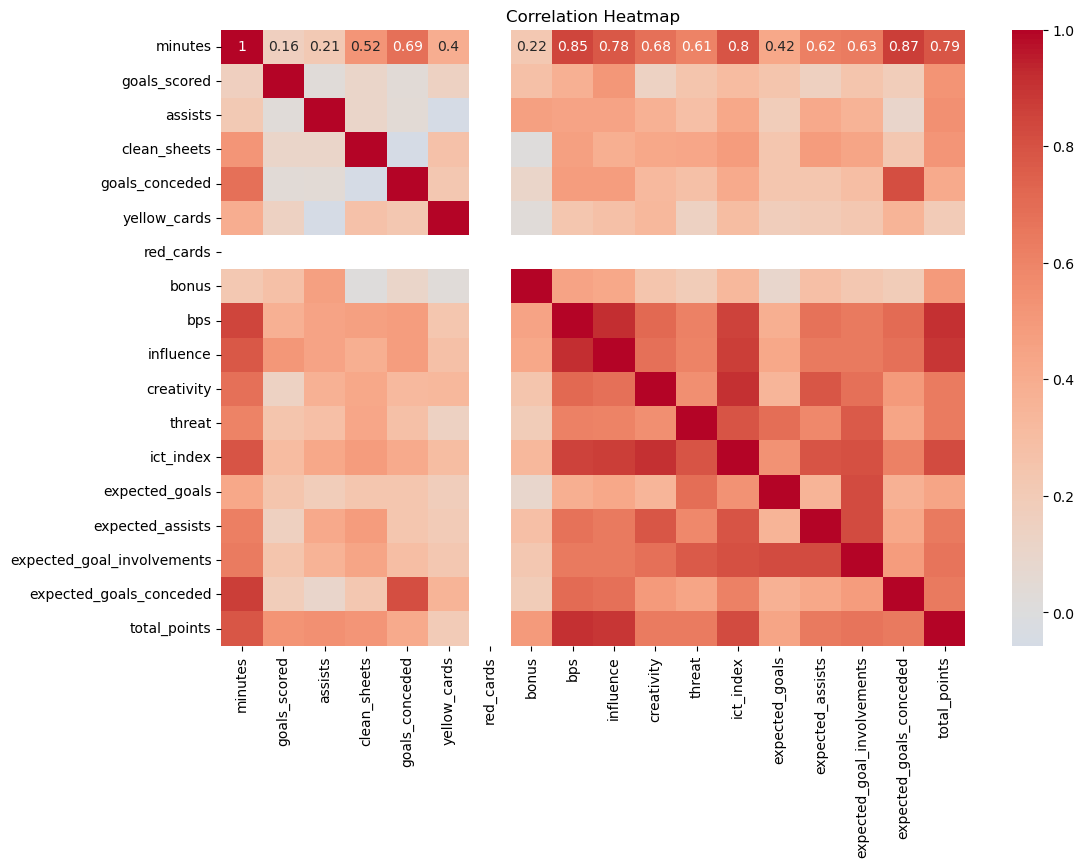

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = midfielders[features + [target]].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


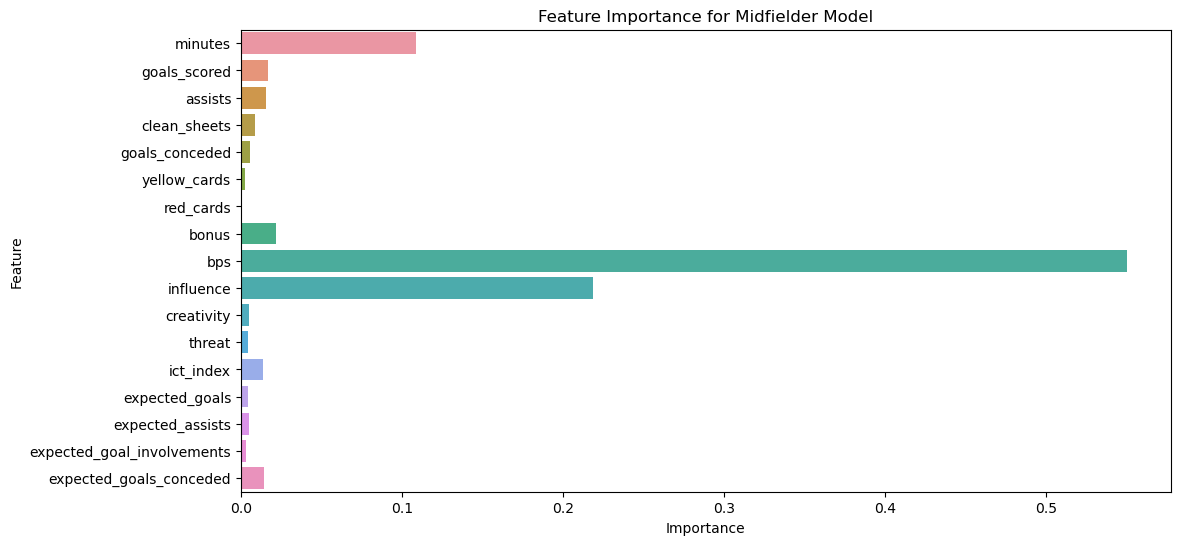

In [9]:
# Feature Importance Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'])
plt.title('Feature Importance for Midfielder Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


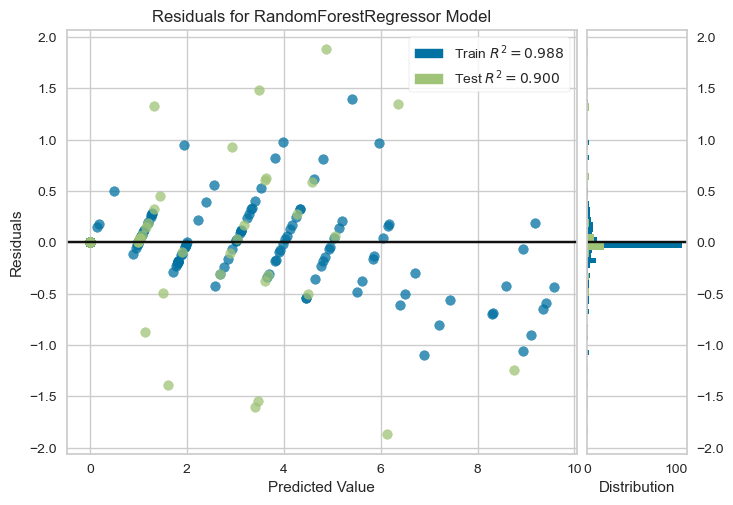

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [11]:
from yellowbrick.regressor import ResidualsPlot

# Initialize ResidualsPlot
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  # Finalize and show the figure


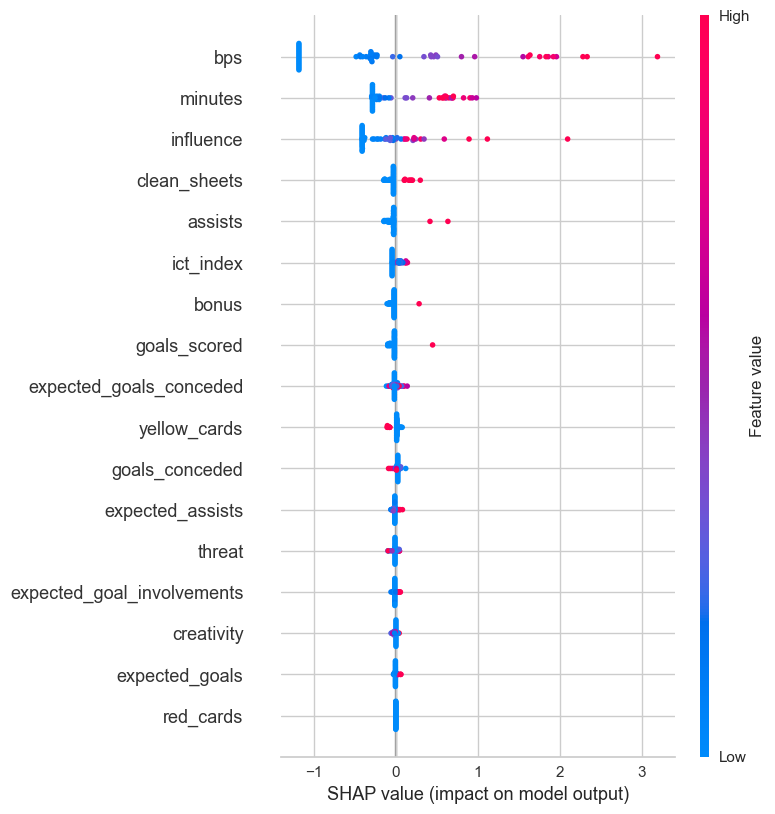

In [16]:
import shap
from sklearn.ensemble import RandomForestRegressor

# Train the model with a compatible type for TreeExplainer
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Initialize the SHAP TreeExplainer and compute SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test, feature_names=features)


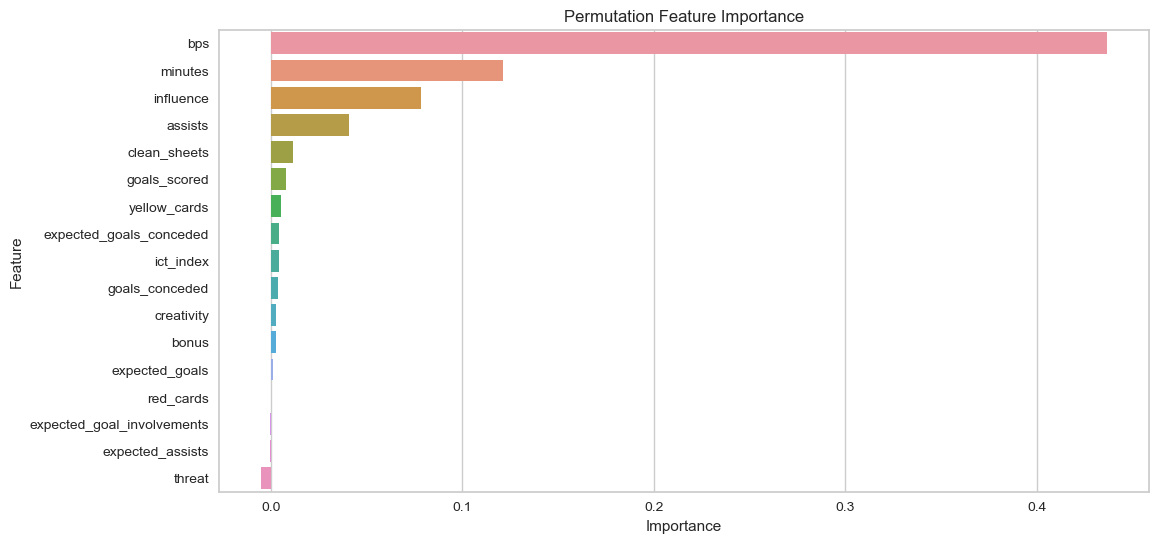

In [17]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# Plot permutation feature importance
perm_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
plt.title('Permutation Feature Importance')
plt.show()


In [19]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline to scale data and train SVM
svm_model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred_svm = svm_model.predict(X_test)

# Evaluate the SVM model
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print(f'SVM Mean Absolute Error: {mae_svm}')
print(f'SVM Mean Squared Error: {mse_svm}')
print(f'SVM R^2 Score: {r2_svm}')


SVM Mean Absolute Error: 0.536038239771727
SVM Mean Squared Error: 0.7679743399567515
SVM R^2 Score: 0.8359764758431196


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search to find the best parameters
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)

# Retrieve the best model from grid search
best_gb_model = grid_search_gb.best_estimator_

# Predict on test data
y_pred_gb = best_gb_model.predict(X_test)

# Evaluate the Gradient Boosting model
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting Best Parameters: {grid_search_gb.best_params_}')
print(f'Gradient Boosting Mean Absolute Error: {mae_gb}')
print(f'Gradient Boosting Mean Squared Error: {mse_gb}')
print(f'Gradient Boosting R^2 Score: {r2_gb}')


Gradient Boosting Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Gradient Boosting Mean Absolute Error: 0.31280567391873815
Gradient Boosting Mean Squared Error: 0.28959658632578805
Gradient Boosting R^2 Score: 0.9381481252672674


In [21]:
# Compile results into a DataFrame for easy comparison
results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Gradient Boosting'],
    'MAE': [mae, mae_svm, mae_gb],
    'MSE': [mse, mse_svm, mse_gb],
    'R2': [r2, r2_svm, r2_gb]
})

print(results.sort_values(by='R2', ascending=False))


               Model       MAE       MSE        R2
2  Gradient Boosting  0.312806  0.289597  0.938148
0      Random Forest  0.396111  0.468994  0.899832
1                SVM  0.536038  0.767974  0.835976


In [22]:
#save best model
import joblib
joblib.dump(best_gb_model, '../models/trained_models/midfielders_model.pkl')

['../models/trained_models/midfielders_model.pkl']

In [25]:
from sklearn.preprocessing import StandardScaler
import joblib

# Load the processed data
df = pd.read_csv('../data/processed/elements_processed.csv')

# Filter for midfielders
midfielders = df[df['element_type'] == 3]

# Select relevant features
features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
    'yellow_cards', 'red_cards', 'bonus', 'bps', 'influence', 'creativity',
    'threat', 'ict_index', 'expected_goals', 'expected_assists',
    'expected_goal_involvements', 'expected_goals_conceded'
]

# Extract the feature set for prediction
X_midfielders = midfielders[features]

# Handle missing values
X_midfielders = X_midfielders.fillna(X_midfielders.mean())

# If you saved the scaler during training, load it
try:
    scaler = joblib.load('../models/trained_models/scaler.pkl')
except FileNotFoundError:
    # If not saved, fit a new scaler but ideally should match training conditions
    scaler = StandardScaler()
    scaler.fit(X_midfielders)  # Fit on the current set to mimic training phase

# Scale the data
X_midfielders_scaled = scaler.transform(X_midfielders)


In [26]:
# Load the best Gradient Boosting model
best_gb_model = joblib.load('../models/trained_models/midfielders_model.pkl')

# Predict the total points for all midfielders
predictions = best_gb_model.predict(X_midfielders_scaled)

# Add predictions to the midfielders DataFrame
midfielders['predicted_points'] = predictions


/var/folders/m3/fdsx0z8944b6_th83kt65w_r0000gn/T/ipykernel_36806/1303233386.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  midfielders['predicted_points'] = predictions


In [27]:
# Sort midfielders by predicted points and select the top 4
top_midfielders = midfielders.sort_values(by='predicted_points', ascending=False).head(4)

# Display the top 4 midfielders
print(top_midfielders[['web_name', 'team_name', 'predicted_points']])


     web_name  team_name  predicted_points
94     Mbeumo  Brentford         10.035069
110   Adingra   Brighton          9.958599
376     Sávio   Man City          9.932518
332  A.Fatawu  Leicester          9.862246


In [28]:
# Save the scaler used during training
joblib.dump(scaler, '../models/trained_models/scaler.pkl')


['../models/trained_models/scaler.pkl']

In [29]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

# Assuming you have the trained Gradient Boosting model
# Load the best Gradient Boosting model
best_gb_model = joblib.load('../models/trained_models/midfielders_model.pkl')

# Feature names in the model
features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
    'yellow_cards', 'red_cards', 'bonus', 'bps', 'influence', 'creativity',
    'threat', 'ict_index', 'expected_goals', 'expected_assists',
    'expected_goal_involvements', 'expected_goals_conceded'
]

# Extract feature importances
importances = best_gb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


                       Feature  Importance
8                          bps    0.529817
9                    influence    0.246448
0                      minutes    0.057946
12                   ict_index    0.037434
1                 goals_scored    0.027935
7                        bonus    0.026900
2                      assists    0.019797
16     expected_goals_conceded    0.019718
3                 clean_sheets    0.012733
11                      threat    0.006208
4               goals_conceded    0.004682
5                 yellow_cards    0.004135
15  expected_goal_involvements    0.003345
14            expected_assists    0.001139
10                  creativity    0.001035
13              expected_goals    0.000728
6                    red_cards    0.000000


In [30]:
# Normalize the feature importances to create weights
feature_importance_df['Weight'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()

# Display the weights
print("Normalized Weights:\n", feature_importance_df[['Feature', 'Weight']])


Normalized Weights:
                        Feature    Weight
8                          bps  0.529817
9                    influence  0.246448
0                      minutes  0.057946
12                   ict_index  0.037434
1                 goals_scored  0.027935
7                        bonus  0.026900
2                      assists  0.019797
16     expected_goals_conceded  0.019718
3                 clean_sheets  0.012733
11                      threat  0.006208
4               goals_conceded  0.004682
5                 yellow_cards  0.004135
15  expected_goal_involvements  0.003345
14            expected_assists  0.001139
10                  creativity  0.001035
13              expected_goals  0.000728
6                    red_cards  0.000000


In [34]:
from sklearn.preprocessing import MinMaxScaler

# Load the processed data
df = pd.read_csv('../data/processed/elements_processed.csv')

# Filter for midfielders (make a copy to avoid SettingWithCopyWarning)
midfielders = df[df['element_type'] == 3].copy()


# Create scaled versions of the relevant features
midfielders['scaled_goals'] = MinMaxScaler().fit_transform(midfielders[['goals_scored']])
midfielders['scaled_assists'] = MinMaxScaler().fit_transform(midfielders[['assists']])
midfielders['scaled_minutes'] = MinMaxScaler().fit_transform(midfielders[['minutes']])
midfielders['scaled_creativity'] = MinMaxScaler().fit_transform(midfielders[['creativity']])
midfielders['scaled_influence'] = MinMaxScaler().fit_transform(midfielders[['influence']])
midfielders['scaled_threat'] = MinMaxScaler().fit_transform(midfielders[['threat']])
midfielders['penalty_cards'] = (midfielders['yellow_cards'] + 2 * midfielders['red_cards']) / midfielders['minutes']

# Calculate the composite metric using the weights from the model
midfielders['composite_metric'] = (
    feature_importance_df.loc[feature_importance_df['Feature'] == 'goals_scored', 'Weight'].values[0] * midfielders['scaled_goals'] +
    feature_importance_df.loc[feature_importance_df['Feature'] == 'assists', 'Weight'].values[0] * midfielders['scaled_assists'] +
    feature_importance_df.loc[feature_importance_df['Feature'] == 'minutes', 'Weight'].values[0] * midfielders['scaled_minutes'] +
    feature_importance_df.loc[feature_importance_df['Feature'] == 'creativity', 'Weight'].values[0] * midfielders['scaled_creativity'] +
    feature_importance_df.loc[feature_importance_df['Feature'] == 'influence', 'Weight'].values[0] * midfielders['scaled_influence'] +
    feature_importance_df.loc[feature_importance_df['Feature'] == 'threat', 'Weight'].values[0] * midfielders['scaled_threat']
)

# Penalize for disciplinary issues (penalties can be scaled similarly if they were significant)
midfielders['composite_metric'] -= midfielders['penalty_cards'] * 0.1 

# Sort by the composite metric to find top performers
top_midfielders_composite = midfielders.sort_values(by='composite_metric', ascending=False).head(4)

# Display the top 4 midfielders using the composite metric
print(top_midfielders_composite[['web_name', 'team_name', 'composite_metric']])


      web_name  team_name  composite_metric
332   A.Fatawu  Leicester          0.315860
550  L.Paquetá   West Ham          0.306884
253      Iwobi     Fulham          0.300893
539      Bowen   West Ham          0.300557
